# Marco Esposito's Solution

# Masked Dataset

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle

In [2]:
#Cell to run on Colab

from google.colab import drive
drive.mount('/content/gdrive')
PATH_DATA = Path("/content/gdrive/My Drive/Tesco_Masked_Dataset/data/masked_dataset/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Cell to run locally

#PATH_DATA = Path('./data/masked_dataset/')

In [4]:
data = pd.read_csv(PATH_DATA / "train.csv")

## Preprocessing

Let's take a look at the data

In [5]:
data.head()

,x1,x2,y
0,0.784119,0.948352,1.437410
1,0.911072,0.787079,0.943558
2,0.549740,0.906819,1.197050
3,0.036095,0.791149,0.408959
4,0.581530,0.609205,0.836620


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      100 non-null    float64
 1   x2      100 non-null    float64
 2   y       100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


In [7]:
data.describe()

,x1,x2,y
count,100.000000,100.000000,100.000000
mean,0.444403,0.523374,0.554952
std,0.288595,0.291111,0.421430
min,0.000457,0.012779,-0.191714
25%,0.222642,0.265002,0.222144
50%,0.401859,0.527564,0.519598
75%,0.682649,0.784647,0.879761
max,0.996337,0.949549,1.499445


There are no missing values in the dataset. Both $x_1$ and $x_2$ are in the interval $(0, 1)$, and have a comparable spread of approximately $0.29$. 

Let's look at the correlations in the dataset

In [8]:
corr = data.corr()
corr

,x1,x2,y
x1,1.000000,0.061202,0.536305
x2,0.061202,1.000000,0.705965
y,0.536305,0.705965,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


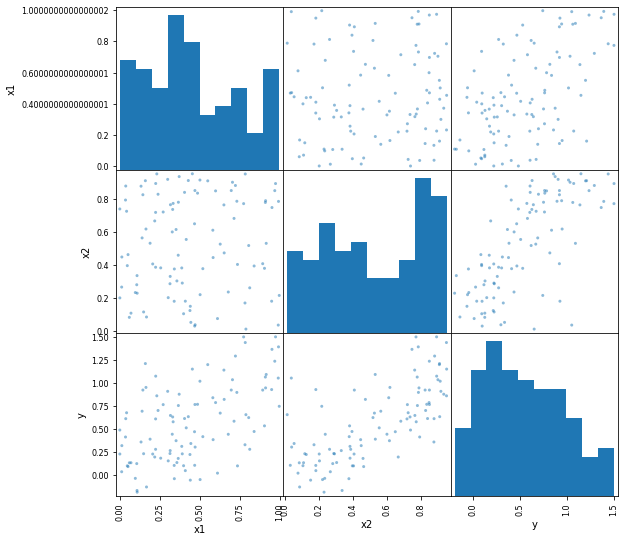

In [9]:
from pandas.plotting import scatter_matrix

fig, ax = plt.subplots(1, 1, figsize=(9, 9))

scatter_matrix(data, ax=ax)
plt.show()

The two features $x_1$ and $x_2$ are uncorrelated, as their scatter plot shows. The correlation with with the target value is $0.53$ and $0.70$ for $x_1$ and $x_2$, respectively.

In [10]:
target = data.y
train = data.drop('y', axis=1)

## Modeling

### Benchmarking with Machine Learning

The target value can - to a first approximation - be seen as linearly dependent on the two features. The number of features is very low, and so is the number of instances. It makes sense to fit some linear models to the data and select the best performing one.

Firstly, we have to transform the data so that they are roughly on the same scale. Let's check whether different scaling options have affect the models' performance. We will use a Standard Scaler and a Robust Scaler. Both of them normalise the data, the difference being in the use of mean and standard deviation for the former and median and Inter Quartile Range for the latter. Median and IQR are robust to outliers, and will better suit for features with anomalous values. 

As for the models used, we have considered:
1. Linear Regression without regularization;
2. LR with Ridge (L2) regularization;
3. LR with Lasso (L1) regularization;
4. LR with Elastic Net regularization (both L1 and L2).

Lastly, we have considered the Mean Squared Error as cost function.

In [11]:
def scale(train, scaler):
    
    trainScaled = pd.DataFrame(scaler.fit_transform(train), columns=['x1', 'x2'])
    
    return trainScaled

In [12]:
scalers = [StandardScaler(), RobustScaler()]

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]

for model in models:
    print(f'model: {model}\n')
    for scaler in scalers:
        trainScaled = scale(train, scaler)
        X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.25, 
                                                           random_state=1)
        model.fit(X_train, y_train)  
        trainError = mean_squared_error(model.predict(X_train), y_train)
        testError = mean_squared_error(model.predict(X_test), y_test)
        print(f'\tscaler: {scaler}, train error: {trainError:.3f}, test error: {testError:.3f}')

model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

	scaler: StandardScaler(copy=True, with_mean=True, with_std=True), train error: 0.042, test error: 0.064
	scaler: RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True), train error: 0.042, test error: 0.064
model: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

	scaler: StandardScaler(copy=True, with_mean=True, with_std=True), train error: 0.044, test error: 0.072
	scaler: RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True), train error: 0.044, test error: 0.072
model: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

	scaler: StandardScaler(copy=True, with_mean=Tru

It seems that:
1. There is no difference between the two scalers;
2. Linear Regression without regularization is the model that performs best.

Using Cross Validation we can get a more realistic estimate of the model performance 

In [13]:
train_scaled = scale(train, StandardScaler())

In [14]:
linModel = LinearRegression()
cvs = cross_val_score(model, train_scaled, target, scoring='neg_mean_squared_error', cv=10)
print(f'{-cvs.mean():.4f}\t{cvs.std():.4f}')

0.1794	0.0594


In [15]:
scaler_ = StandardScaler()

train_scaled = scale(train, scaler_)

linModel.fit(train_scaled, target)
linModel.coef_, linModel.intercept_

(array([0.20754204, 0.28332142]), 0.5549524001167554)

In [16]:
linModel.score(train_scaled, target)

0.7424472892688672

To recap: we have assumed that the response variable ($y$) is linearly dependent on the two features $x_1, x_2$. This means that a change in either will result in a proportional change in $y$. Fitting this model has output the important information that changes feature $x_2$ lead to larger changes in the $y$ compared to changes in $x_1$, though not by a lot. Let's now turn to a Bayesian setting. 

### Bayesian Linear Regression

The assumptions on the model are the following: 

$y = \alpha x_1 + \beta x_2 + \gamma + \epsilon$ 

where:

$\alpha, \beta \sim U(-0.5, 1.5)$,

$\gamma \sim U(-2, 2)$,

and

$\epsilon \sim \mathcal{N}(0, \sigma^2)$

that is, $y$ is a linear function of the two variables $x_1, x_2$ plus a Gaussian noise with standard deviation $\sigma$. What we will do now is performing inference on the four parameters $\alpha, \beta, \gamma, \sigma$. We will do so using a python library pymc3.

In [17]:
#I've had several problems making pymc3 work - it seems that different versions of arviz and pymc3 
#have compatibility problems. In case this setting does not work on your machine, 
#do let me know so that I can share the notebook in some other way.

!pip install pymc3==3.10
!pip install arviz==0.10.0
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)

In [18]:
train_scaled = scale(train, StandardScaler())

Let's define the model in pymc3

In [19]:
cut = -1
x1 = train_scaled.x1[:cut]
x2 = train_scaled.x2[:cut]


reg_model = pm.Model()
with reg_model:
    # Regression coeffients
    alpha = pm.Uniform('alpha', -0.5, 1.5)
    beta = pm.Uniform('beta', -0.5, 1.5)
    gamma = pm.Uniform('gamma', -2, 2)

    # Expected value
    mu = alpha*x1 + beta*x2 + gamma
    
    # Standard deviation of the noie
    sd = pm.HalfNormal('sd',sd=2)
    
    # Noisy observation with normal-distributed noise
    Y_obs = pm.Normal('target', sd=sd, mu=mu, observed=target[:cut])

Let's get the samples from the posterior distribution of the parameters using Hamiltonian Monte Carlo

In [20]:
with reg_model:
  trace = pm.sample(2000, chains=2, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, gamma, beta, alpha]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 6 seconds.


Done! Now it's important that we check the trace plots to make sure they are convergent and stationary

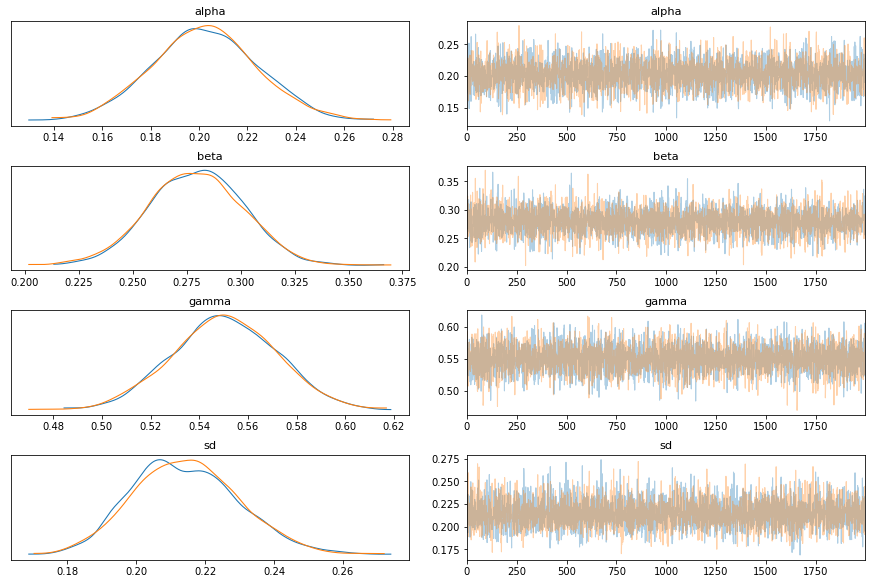

In [21]:
az.plot_trace(trace);

They look good! Let's also take a look at the autocorrelation of the samples

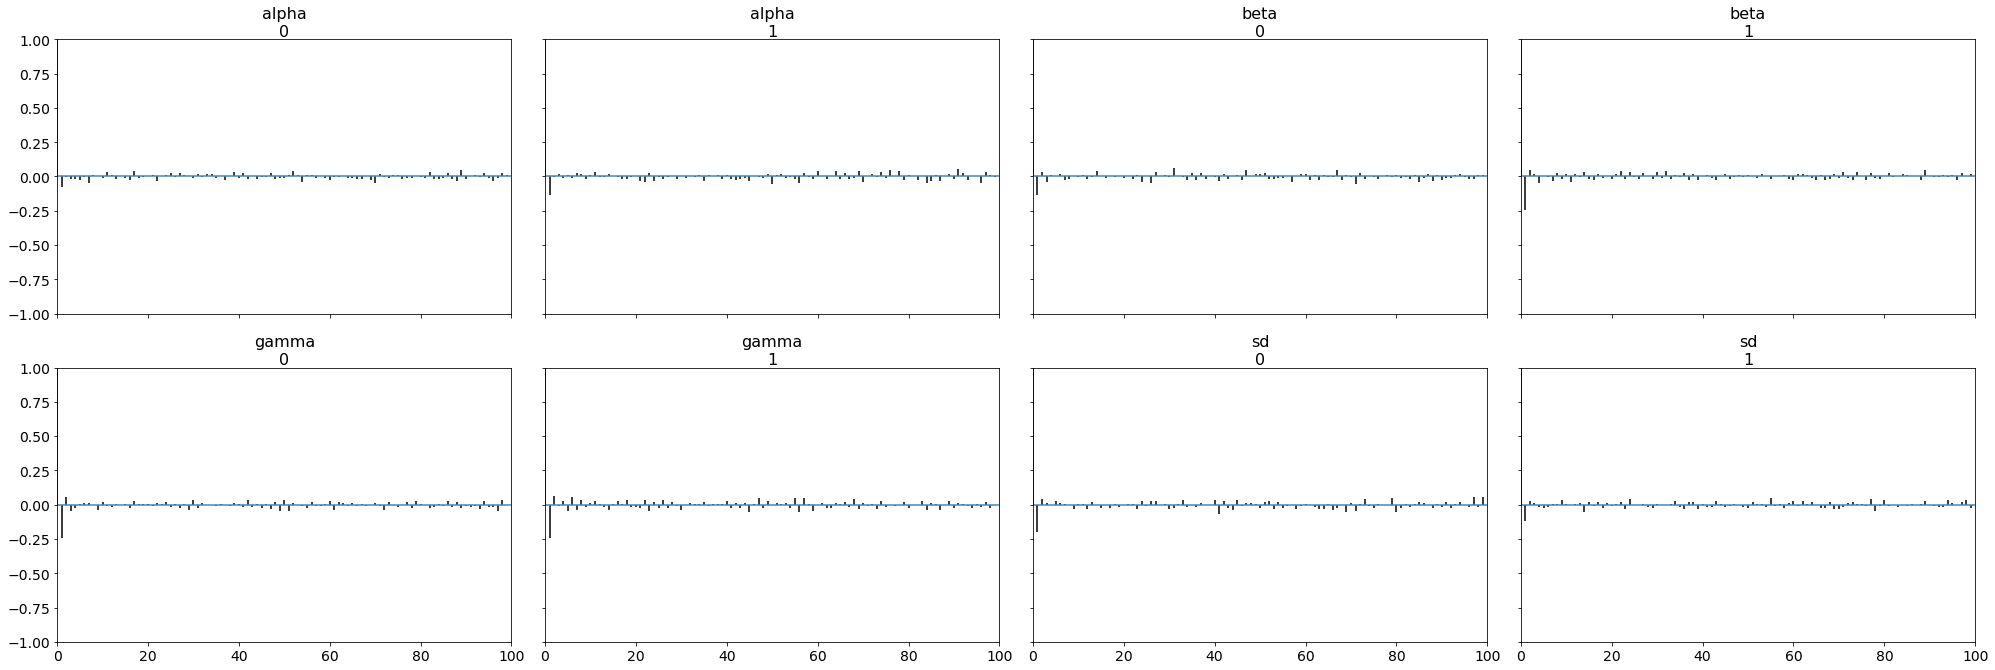

In [22]:
az.plot_autocorr(trace);

The above plots suggest that the samples drawn from the chains are virtually completely uncorrelated. Both the trace and autocorrelation plots ensure that the sampling has been carried out correctly.

Let's now turn to the posterior distributions of the parameters and some summary statistics.

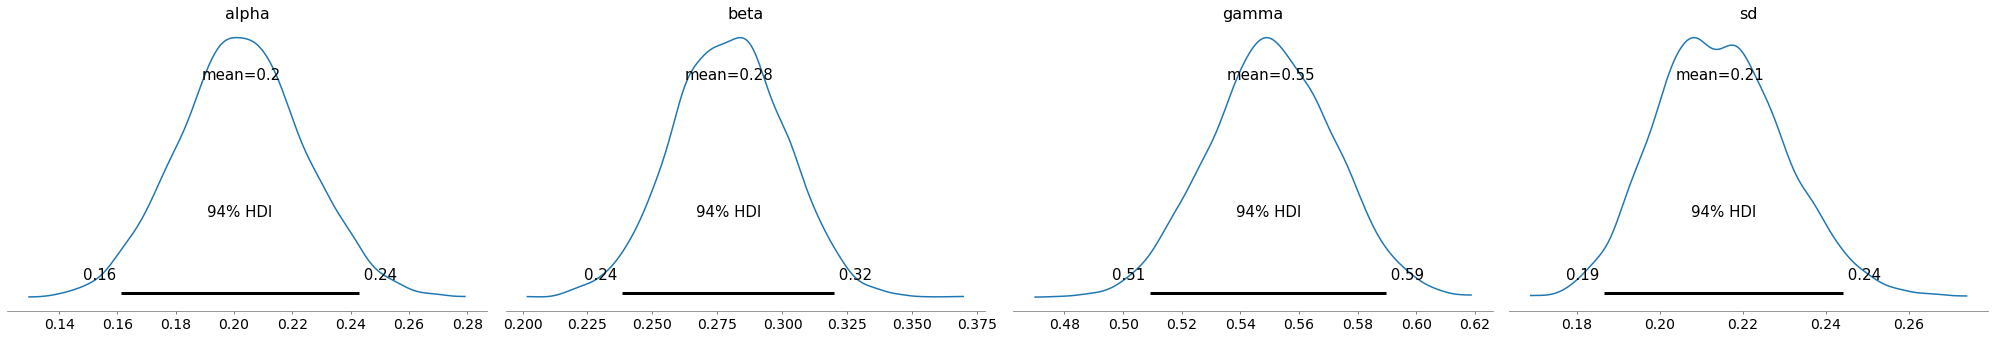

In [23]:
az.plot_posterior(trace);

In [24]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.202,0.022,0.161,0.243,0.0,0.0,5061.0,5043.0,5058.0,3316.0,1.0
beta,0.279,0.022,0.238,0.320,0.0,0.0,5864.0,5820.0,5904.0,3252.0,1.0
gamma,0.550,0.022,0.509,0.590,0.0,0.0,6925.0,6925.0,6916.0,3279.0,1.0
sd,0.215,0.016,0.187,0.244,0.0,0.0,5184.0,5184.0,5082.0,3005.0,1.0


The mean values of the posterior distributions for $\alpha, \beta$ and $\gamma$ closely match the values estimated through ML Linear Regression. We are also given information about the $94\%$ High Density Interval (HDI), which is the narrowest interval where $94\%$ of the posterior lies.

We can also look at the Posterior Predictive Distribution (PPD), which is the distribution of $y$ obtained by drawing a number of unique values of $\alpha, \beta, \gamma, \sigma$ from the posterior distributions above, and simulating them model forward.

In [25]:
# Draw samples for the PPD

RND = 10

with reg_model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=['alpha', 'beta', 'gamma', 'sd', 'target'], random_seed=RND
    )

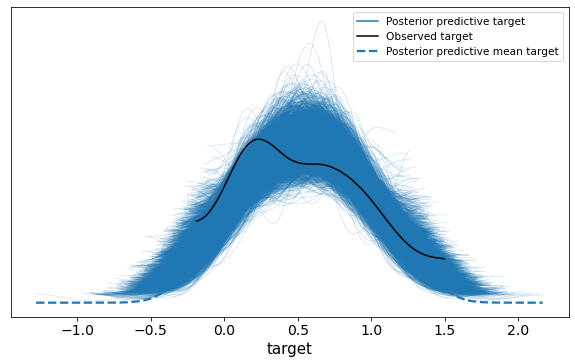

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5.7))
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=reg_model), ax=ax);

The above plot shows us that the model performs reasonably well in terms of retrodicting the data. Also it gives us an idea of the uncertainty on the result we can expect from the model.

Let's now look some more at the parameters

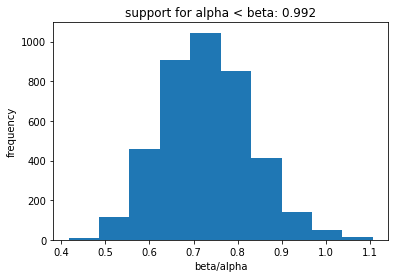

In [27]:
ratioAlphaBeta = np.sum(trace['alpha'] < trace['beta'])/len(trace['alpha'])
plt.hist(trace['alpha']/trace['beta'])
plt.title(f'support for alpha < beta: {ratioAlphaBeta:.3f}')
plt.xlabel('beta/alpha')
plt.ylabel('frequency')
plt.show()

In [28]:
pm.summary(trace['alpha']/trace['beta'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.729,0.101,0.542,0.91,0.001,0.001,4845.0,4771.0,4843.0,3235.0,NaN


The model strongly supports the conclusion that $\beta > \alpha$, that is to say, changes in $x_1$ has a smaller impact on $y$ with respect to changes in $x_2$.

Also, there is little covariation between parameters (not shown here).

## In conclusion

We have fit two models on the masked dataset, both of which make use of the assumptions of the target $y$ being a linear function of the predictors $x_1, x_2$ plus a gaussian noise. This ensures a straightfoward interpretability of the results. The first was a Linear Regression performed in the context of Machine Learning, that gave us Maximum Likelihood Estimates of the parameters, but didn't allow us to easily return an estimate of the uncertainties on the predictions.

To have this, we have resorted to Bayesian Linear Regression. As anticipated, the underlying assumptions on the functional dependence between $y$ and the features is unchanged, but the Bayesian setting more naturally accounts for uncertainty in the modeling.

In short, what we have found is that the linear hypothesis seems a sensible one, in terms of retrodicting the data: changes in either one of the predictors will lead to proportional changes in the response variable. Also, we are very confident about the fact that $y$ is more sensitive to changes in $x_2$, and we have information about their ratio (mean, std = $0.728, 0.102$).

Importantly, we have shown the posterior predictive distribution of $y$: from this, we can calculate summary statistics and estimate the uncertainty in possible predictions we will make with this model.